In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Import machine learning libraries
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

from joblib import dump, load


from pmdarima import auto_arima
import fbprophet
pd.plotting.register_matplotlib_converters()
from tbats import TBATS, BATS
import datetime as dt
from datetime import datetime
import time
from time import sleep

In [2]:
df = pd.read_csv('../data/processed/traffic_for_modelling.csv')

In [3]:
df

,index,Value,Holiday,time,mdate,day,week,month,year
0,2015-01-01 10:00,8.0,New Year's Day,10,1,3,1,1,2015
1,2015-01-01 11:00,14.0,New Year's Day,11,1,3,1,1,2015
2,2015-01-01 12:00,28.0,New Year's Day,12,1,3,1,1,2015
3,2015-01-01 13:00,33.0,New Year's Day,13,1,3,1,1,2015
4,2015-01-01 14:00,47.0,New Year's Day,14,1,3,1,1,2015
...,...,...,...,...,...,...,...,...,...
29311,2018-05-06 17:00,27.0,NaN,17,6,6,18,5,2018
29312,2018-05-06 18:00,14.0,NaN,18,6,6,18,5,2018
29313,2018-05-06 19:00,4.0,NaN,19,6,6,18,5,2018
29314,2018-05-06 20:00,0.0,NaN,20,6,6,18,5,2018


In [4]:
df['index'] = pd.to_datetime(df['index'])

In [5]:
df.set_index('index', inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29316 entries, 2015-01-01 10:00:00 to 2018-05-06 21:00:00
Data columns (total 8 columns):
Value      29316 non-null float64
Holiday    791 non-null object
time       29316 non-null int64
mdate      29316 non-null int64
day        29316 non-null int64
week       29316 non-null int64
month      29316 non-null int64
year       29316 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 2.0+ MB


In [7]:
df.isna().sum()

Value          0
Holiday    28525
time           0
mdate          0
day            0
week           0
month          0
year           0
dtype: int64

In [8]:
df.loc[df['Holiday'].isnull(), 'Holiday'] = 'Non Holiday'

In [9]:
df.isna().sum()

Value      0
Holiday    0
time       0
mdate      0
day        0
week       0
month      0
year       0
dtype: int64

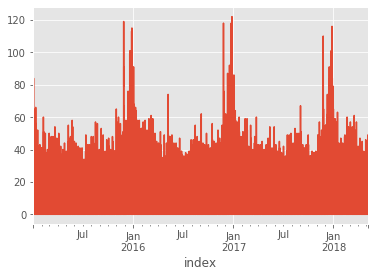

In [10]:
df['Value'].plot()

# Splitting Train and Test Set

In [11]:
len(df)

29316

In [12]:
df.index.min()

Timestamp('2015-01-01 10:00:00')

In [13]:
df.index.max()

Timestamp('2018-05-06 21:00:00')

We can set aside 20% of the data points for test set and training on the remaining 80%.
The cutoff point will be September 2017 as that equates roughly to 80% of our available datapoints.

In [14]:
# Set train/test time split

train_start = pd.to_datetime('20150101 1000', format='%Y-%m-%d %H:%M')
test_start  = pd.to_datetime('20170901 0000', format='%Y-%m-%d %H:%M')
 
train_end   = test_start
test_end    = pd.to_datetime('20180506 2100', format='%Y-%m-%d %H:%M')  

# Assign train/test data frames
data_training = df[train_start:test_start]
data_test = df [test_start:test_end]

In [15]:
data_training = data_training['Value']

In [16]:
data_test = data_test['Value']

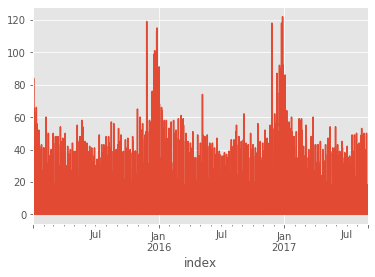

In [17]:
data_training.plot()
plt.show()

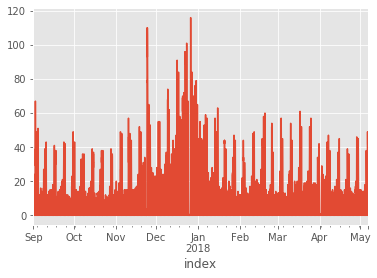

In [18]:
data_test.plot()
plt.show()

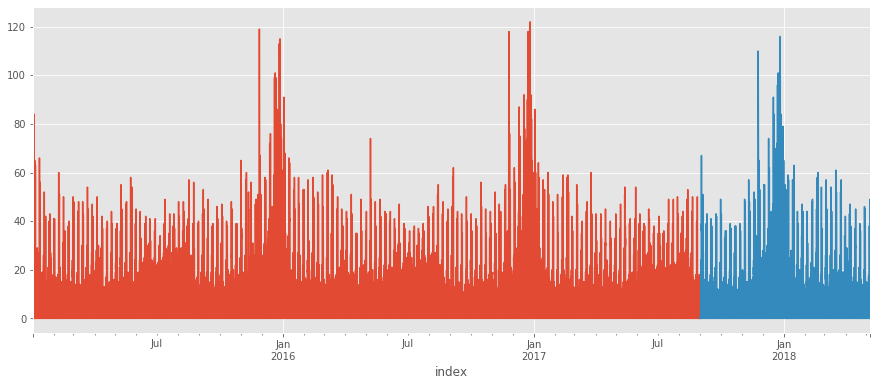

In [19]:
rcParams['figure.figsize'] = 15, 6

ax = data_training.plot(label = 'Train')
ax = data_test.plot (label = 'Testing')

In [20]:
data_test

index
2017-09-01 00:00:00     0.0
2017-09-01 01:00:00     0.0
2017-09-01 02:00:00     0.0
2017-09-01 03:00:00     1.0
2017-09-01 04:00:00     0.0
                       ... 
2018-05-06 17:00:00    27.0
2018-05-06 18:00:00    14.0
2018-05-06 19:00:00     4.0
2018-05-06 20:00:00     0.0
2018-05-06 21:00:00     1.0
Name: Value, Length: 5950, dtype: float64

In [21]:
data_training

index
2015-01-01 10:00:00     8.0
2015-01-01 11:00:00    14.0
2015-01-01 12:00:00    28.0
2015-01-01 13:00:00    33.0
2015-01-01 14:00:00    47.0
                       ... 
2017-08-31 20:00:00     6.0
2017-08-31 21:00:00     0.0
2017-08-31 22:00:00     0.0
2017-08-31 23:00:00     0.0
2017-09-01 00:00:00     0.0
Name: Value, Length: 23367, dtype: float64

# Investigate Autocorrelation (ACF) and Partial Autocorrelation (PACF) 

As can be seen, there are significant negative/positive spikes in the ACF plot at lag 6,12 and lag 24 (intra daily seasonal component). In the PACF plot, there are significant negative spikes at lags 1 and 2 and 24.

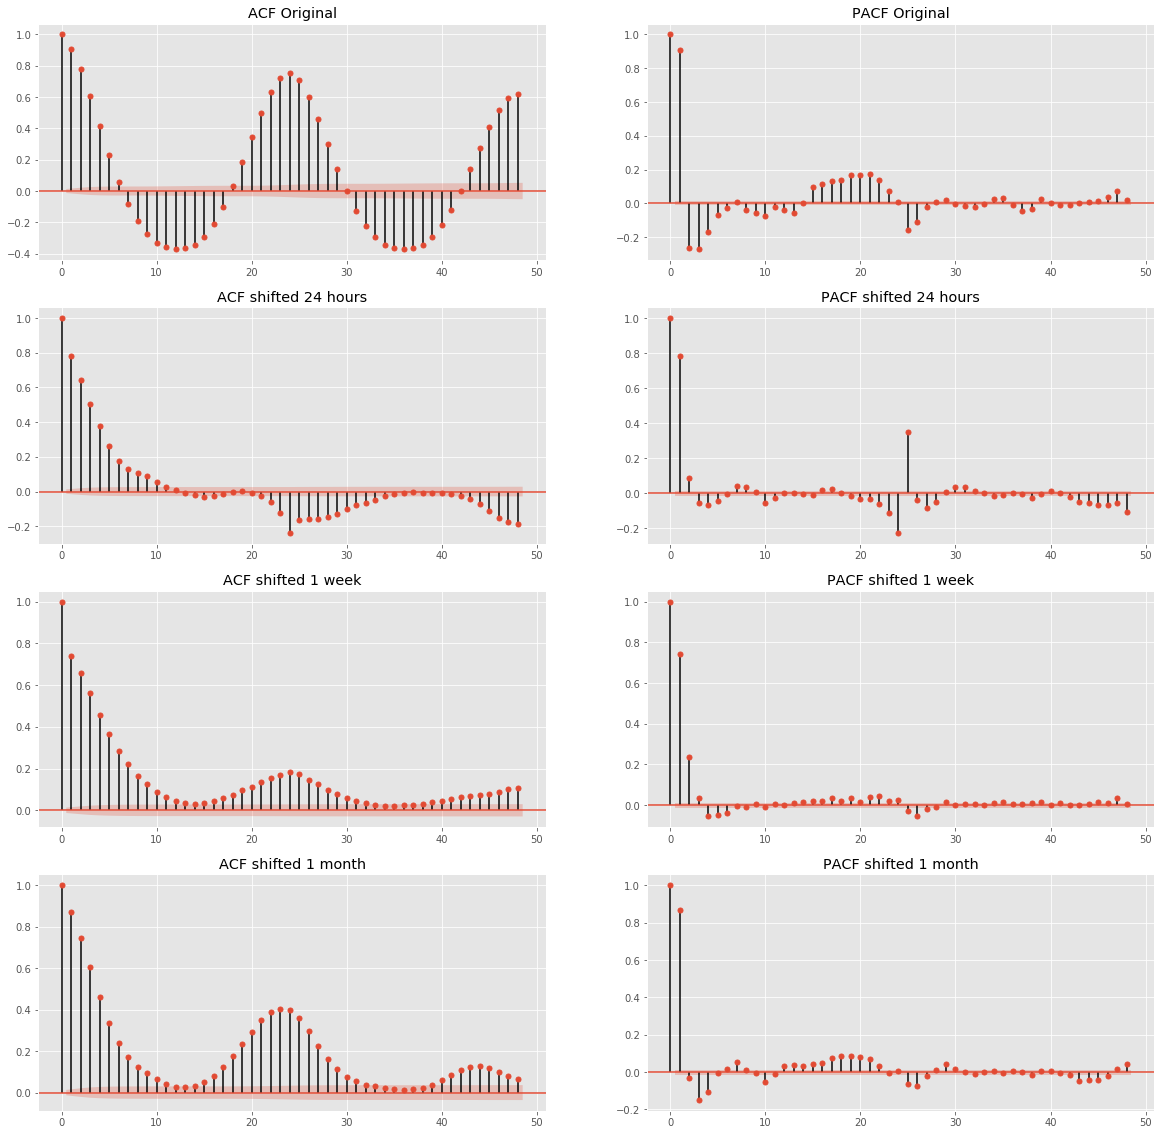

In [22]:

# Zoom in lags over 2 days
lags = 24*2 # hours
one_day = pd.Timedelta(hours=24)

data_shift_day  = data_training - data_training.shift(24)
data_shift_week = data_training - data_training.shift(24*7)
data_shift_month = data_training - data_training.shift(24*30)
data_shift_year = data_training - data_training.shift(24*365)

# Adjust time window since shifted data has null values at the start
data_shift_day_p  = data_shift_day[train_start + one_day:]
data_shift_week_p = data_shift_week[train_start + one_day * 7:]
data_shift_monthly_p = data_shift_month[train_start + one_day * 30:]
data_shift_year_p = data_shift_year[train_start + one_day * 365:]



# # Plot ACF & PCF
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20,20))
plot_acf (data_training, lags=lags, ax=axes.flat[0], title='ACF Original')
plot_pacf(data_training, lags=lags, ax=axes.flat[1], title='PACF Original')
plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[2], title='ACF shifted 24 hours')
plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[3], title='PACF shifted 24 hours')
plot_acf (data_shift_week_p, lags=lags, ax=axes.flat[4], title='ACF shifted 1 week')
plot_pacf(data_shift_week_p, lags=lags, ax=axes.flat[5], title='PACF shifted 1 week')
plot_acf (data_shift_monthly_p, lags=lags, ax=axes.flat[6], title='ACF shifted 1 month')
plot_pacf(data_shift_monthly_p, lags=lags, ax=axes.flat[7], title='PACF shifted 1 month');
# plot_acf (data_shift_year_p, lags=lags, ax=axes.flat[8], title='ACF shifted 1 year')
# plot_pacf(data_shift_year_p, lags=lags, ax=axes.flat[9], title='PACF shifted 1 year');




# Baseline SARIMA Model

It is not very easy to determine optimal values for p and q from this data but the below could be a starting point. However, my machine is not powerful enough to try combinations of p and q >2 even though the SARIMA model is usually quite quick.

In [23]:
# Determine baseline SARIMA parameters from the latest ACF & PACF

p = 6  # lag from PACF
d = 1  # non-seasonal differences taken to get stationarity
q = 7  # lag from ACF
m = 24 # cycle repeats after 24 hours
P = 2  # follows p
D = 1  # follows d
Q = 2  # follows q

Due to the high amount of data and granularity I am unable to implement SARIMA models with variations of p,q values other than 0 and 1.
I am constrained by the memory of my laptop to perform a baseline SARIMA modelling only with autoregressive value p equal to 1, differencing by one to reduce seasonality and moving average value q equal to 1.

Although there are several seasonalities within this dataset (yearly, weekly, daily), SARIMA can only take into account one type of seasonality. 

In this case, I picked a daily seasonal value defined by 24 since we are trying to build a model that will predict values based on hourly granular data.


In [24]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data_training, 
                                        order=(1,1,1), 
                                        seasonal_order=(1, 1, 1, 24), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary())

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                23367
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -68465.956
Date:                            Wed, 17 Jun 2020   AIC                         136941.912
Time:                                    09:56:46   BIC                         136982.197
Sample:                                01-01-2015   HQIC                        136954.995
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3167      0.031    -10.112      0.000      -0.378      -0.255
ma.L1          0.2065      0.032   

The AIC value is really high pointing to a not so good model. We'll perform more detailed diagnostic on this model in the next sections.

## One step-ahead forecasting

Below, I am creating some predictions over the test set period of time. Even though I am creating confidence intervals too, I won't be plotting them because they are very large and they mess up with the scale of training, test and forecast values.

In front of stakeholder and with a more refined model, I would definitely make sure to also include confidence intervals just to make clear that our forecast are not exact.

For get_predictions(), I'll set the dynamic parameter to False to ensure that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point

In [25]:
pred = output.get_prediction(start=test_start, end=test_end, dynamic=False, full_results=True)
pred_conf = pred.conf_int()
pred_conf

,lower Value,upper Value
2017-09-01 00:00:00,-8.913212,8.940582
2017-09-01 01:00:00,-8.877562,8.976231
2017-09-01 02:00:00,-11.725716,12.173364
2017-09-01 03:00:00,-14.545678,14.501664
2017-09-01 04:00:00,-16.679436,16.635093
...,...,...
2018-05-06 17:00:00,-4137.105308,4172.707776
2018-05-06 18:00:00,-4141.241459,4170.453549
2018-05-06 19:00:00,-4144.669220,4168.907285
2018-05-06 20:00:00,-4150.182379,4165.275199


## Checking for Residuals and Model Assumptions

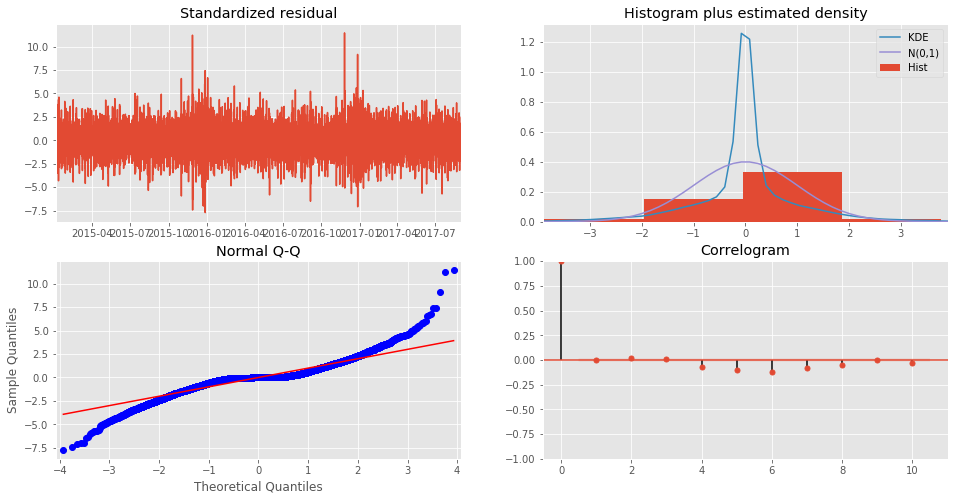

In [26]:
output.plot_diagnostics(figsize=(16, 8))
plt.show()

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.


In the top right plot, we see that the blue KDE line does not follow closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is unfortunately a strong indication that the residuals are not normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) also does not follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are not normally distributed.

The residuals over time (top left plot) display some obvious seasonality. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have high correlation with lagged versions of themselves.

All these signs point to the fact that the model will probably not be able to make solid forecast. Something we knew already from the very high AIC value displayed in the model.

## Visualising Training, Test and Forecast 

It is very obvious to see that the model hasn't picked yearly and monthly seasonality and the usual spike of December traffic was not displayed in the forecast. Also, the whole of the test set forecast (in purple) appears completely flat at first glance.

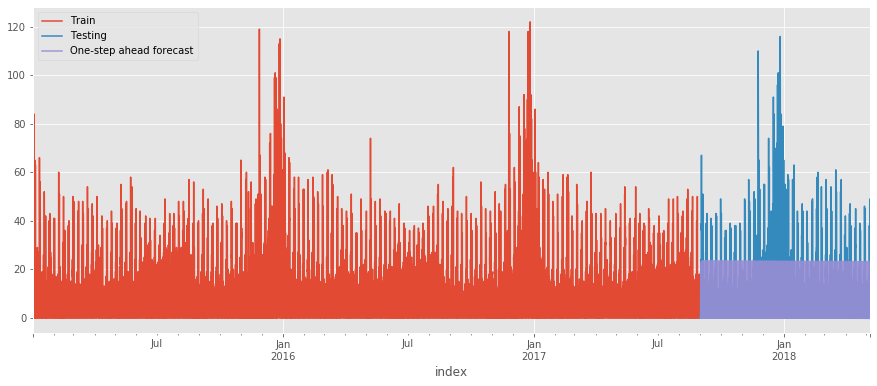

In [27]:
rcParams['figure.figsize'] = 15, 6
# plot for training observed values
ax = data_training.plot(label = 'Train')

# plot for test observed values
ax = data_test.plot (label = 'Testing')

# plot of rthe predictions
pred.predicted_mean.plot(ax=ax, label = 'One-step ahead forecast', alpha = 25)

ax.set_label('Date')
ax.set_label('Traffic')

plt.legend()
plt.show()


### Zooming in on test set

However, some degree of seasonality slowly starts to appear as we zoom in on the test_set. 

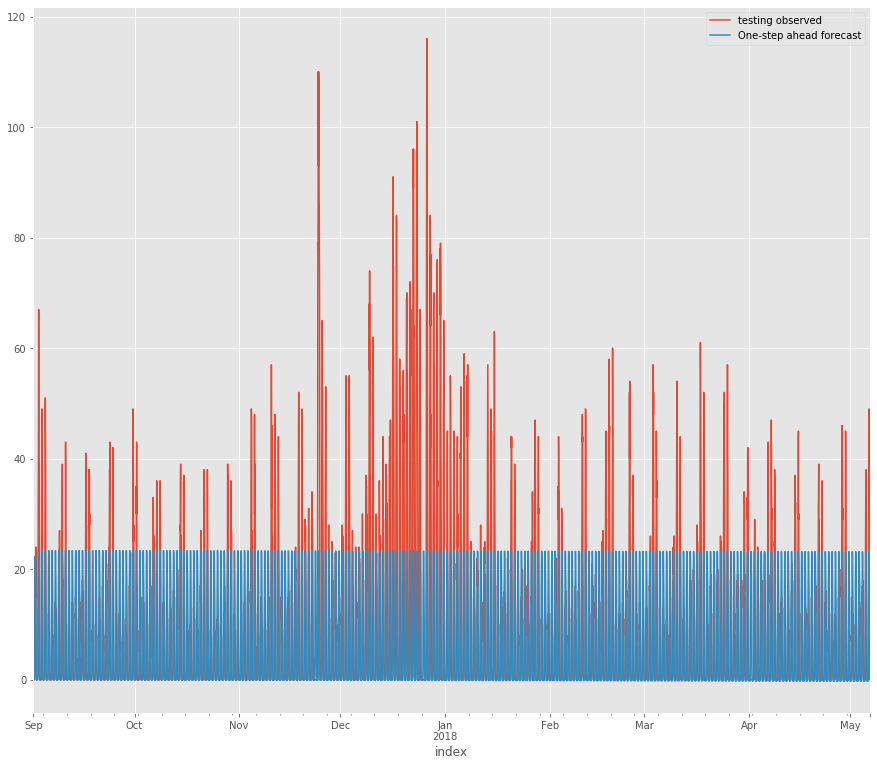

In [28]:
rcParams['figure.figsize'] = 15,13

ax = data_test.plot(label='testing observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=1)

ax.set_label('Date')
ax.set_label('Traffic')
plt.legend()
plt.show()

###   Zooming in on weekly results

In [29]:
week_test = data_test['2018-02-14 23:00:00':'2018-02-21']

In [30]:
week_test

index
2018-02-14 23:00:00    0.0
2018-02-15 00:00:00    0.0
2018-02-15 01:00:00    1.0
2018-02-15 02:00:00    0.0
2018-02-15 03:00:00    0.0
                      ... 
2018-02-21 19:00:00    9.0
2018-02-21 20:00:00    6.0
2018-02-21 21:00:00    0.0
2018-02-21 22:00:00    0.0
2018-02-21 23:00:00    0.0
Name: Value, Length: 169, dtype: float64

In [31]:
pred_week = output.get_prediction(start=pd.to_datetime('2018-02-14 23:00:00'), end=pd.to_datetime('2018-02-21 23:00:00'), dynamic=False, full_results=True)
pred_conf = pred.conf_int()
pred_conf

,lower Value,upper Value
2017-09-01 00:00:00,-8.913212,8.940582
2017-09-01 01:00:00,-8.877562,8.976231
2017-09-01 02:00:00,-11.725716,12.173364
2017-09-01 03:00:00,-14.545678,14.501664
2017-09-01 04:00:00,-16.679436,16.635093
...,...,...
2018-05-06 17:00:00,-4137.105308,4172.707776
2018-05-06 18:00:00,-4141.241459,4170.453549
2018-05-06 19:00:00,-4144.669220,4168.907285
2018-05-06 20:00:00,-4150.182379,4165.275199


The model has picked up only the daily cycle (set up by the arima model with the value 24 in the seasonal_order param) but it's unable to differentiate weekly results and it's averaging every single day to have the same value by the hour.

In [ ]:
rcParams['figure.figsize'] = (15,15)

plt.title('Traffic per hour')

ax = week_test.plot(label='test_week')
pred_week.predicted_mean.plot(ax=ax, label = 'prediction over a week', alpha = 1)



plt.show()

The model so far has been able to pick up roughly daily patterns but it's not detecting weekly variations. 17th and 18th Feb 2018 were indeed a weekend.

**I am not performing dynamic forecast for the extra month outside of the dataset given the very low performance also confirmed by the MSE value below:**

In [33]:
# Get the real and predicted values
traffic_forecasted = pred.predicted_mean
traffic_truth = data_test

# Compute the mean square error
mse = ((traffic_forecasted - traffic_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 127.49


# 2nd SARIMA iteration with less data points and weekly seasonality

Since we are trying to predict only an extra month only, it is sensible to reduce some of in the information provided and see if we can perform some gridsearch optimisation on p,d values. (although generally speaking not ideal because we are losing precious information).

At the same time, I'll try to implement weekly seasonality instead to see if performance goes up.

As the final goal is to predict one month in granular hourly data, I'll just keep the previous 5 months (roughly equal to a 80% test set in terms of datapoints.)

In [34]:
# last 5 months
data_2 = df['2018':]

In [35]:
data_2 = data_2['Value']

In [36]:
data_2

index
2018-01-01 00:00:00     0.0
2018-01-01 01:00:00     0.0
2018-01-01 02:00:00     0.0
2018-01-01 03:00:00     0.0
2018-01-01 04:00:00     0.0
                       ... 
2018-05-06 17:00:00    27.0
2018-05-06 18:00:00    14.0
2018-05-06 19:00:00     4.0
2018-05-06 20:00:00     0.0
2018-05-06 21:00:00     1.0
Name: Value, Length: 3022, dtype: float64

## Splitting into training and test the new df

In [37]:
# splitting into training and test the new df

# Set train/test time split

train_start_2 = pd.to_datetime('20180101 0000', format='%Y-%m-%d %H:%M')
test_start_2  = pd.to_datetime('20180401 0000', format='%Y-%m-%d %H:%M')
 
train_end_2   = test_start
test_end_2    = pd.to_datetime('20180506 2100', format='%Y-%m-%d %H:%M')  

# Assign train/test data frames
data_training_2 = data_2[train_start_2:test_start_2]
data_test_2 = data_2[test_start_2:test_end_2]



In [38]:
data_training_2

index
2018-01-01 00:00:00     0.0
2018-01-01 01:00:00     0.0
2018-01-01 02:00:00     0.0
2018-01-01 03:00:00     0.0
2018-01-01 04:00:00     0.0
                       ... 
2018-03-31 20:00:00    16.0
2018-03-31 21:00:00     0.0
2018-03-31 22:00:00     1.0
2018-03-31 23:00:00     0.0
2018-04-01 00:00:00     0.0
Name: Value, Length: 2161, dtype: float64

In [39]:
ARIMA_MODEL_2 = sm.tsa.statespace.SARIMAX(data_training_2, 
                                        order=(1,1,1), 
                                     
                                        seasonal_order=(1, 1, 1, 53), # changing to weekly seasonality  
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output_2 = ARIMA_MODEL_2.fit()

print(output.summary())

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                23367
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -68465.956
Date:                            Wed, 17 Jun 2020   AIC                         136941.912
Time:                                    10:00:21   BIC                         136982.197
Sample:                                01-01-2015   HQIC                        136954.995
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3167      0.031    -10.112      0.000      -0.378      -0.255
ma.L1          0.2065      0.032   

Unfortunately, results are not promising even in this iteration. 

Also, computational speed did not benefit majorly from the cut in data points and **gridsearch** with parameters outside of the range (0,2) did not work at all. I haven't attached the gridsearch because it was quite slow and very pointless with values ranging only from 0 to 2 for all parameters. AIC did not decrease significantly and it was always around 150000 (quite bad).

In [40]:
pred_2 = output_2.get_prediction(start=test_start_2, end=test_end_2, dynamic=False, full_results=True)
pred_conf_2 = pred_2.conf_int()
pred_conf_2

,lower Value,upper Value
2018-04-01 00:00:00,-11.380957,9.995089
2018-04-01 01:00:00,-11.938755,9.437291
2018-04-01 02:00:00,-17.284684,16.542242
2018-04-01 03:00:00,-22.317573,22.301728
2018-04-01 04:00:00,-27.080025,27.143022
...,...,...
2018-05-06 17:00:00,-569.647422,567.128856
2018-05-06 18:00:00,-570.406429,567.237132
2018-05-06 19:00:00,-570.064369,568.445854
2018-05-06 20:00:00,-570.447990,568.928248


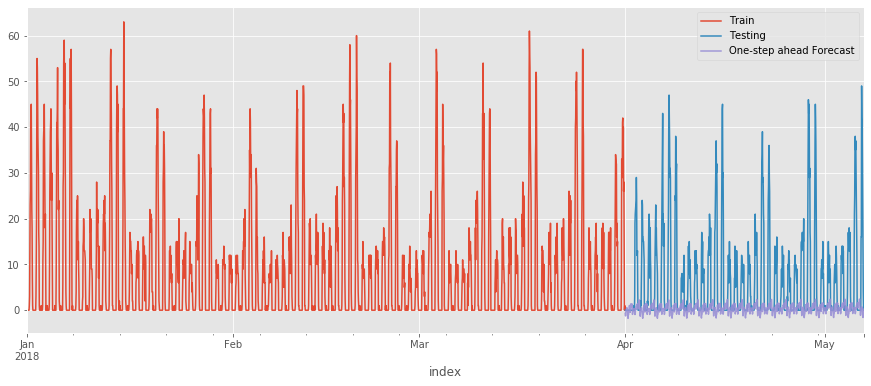

In [41]:
rcParams['figure.figsize'] = 15,6

ax = data_training_2.plot(label = 'Train')

ax = data_test_2.plot (label = 'Testing')

pred_2.predicted_mean.plot(ax=ax, label = 'One-step ahead Forecast', alpha = 30)

plt.legend()
plt.show()


In [42]:
week_test_2 = data_test_2['2018-04-14 23:00:00':'2018-04-21 00:00:00']
pred_week_2 = output_2.get_prediction(start= pd.to_datetime('2018-04-14 23:00:00'), end =pd.to_datetime('2018-04-21 23:00:00'), dynamic=False, full_results=True)
pred_conf_week = pred_week_2.conf_int()
pred_conf_week

,lower Value,upper Value
2018-04-14 23:00:00,-322.680450,322.934035
2018-04-15 00:00:00,-323.695123,323.022030
2018-04-15 01:00:00,-323.463679,324.353833
2018-04-15 02:00:00,-322.962698,325.953044
2018-04-15 03:00:00,-324.315499,325.696464
...,...,...
2018-04-21 19:00:00,-405.836233,408.122537
2018-04-21 20:00:00,-406.688650,408.241331
2018-04-21 21:00:00,-406.446807,409.453191
2018-04-21 22:00:00,-406.986882,409.881960


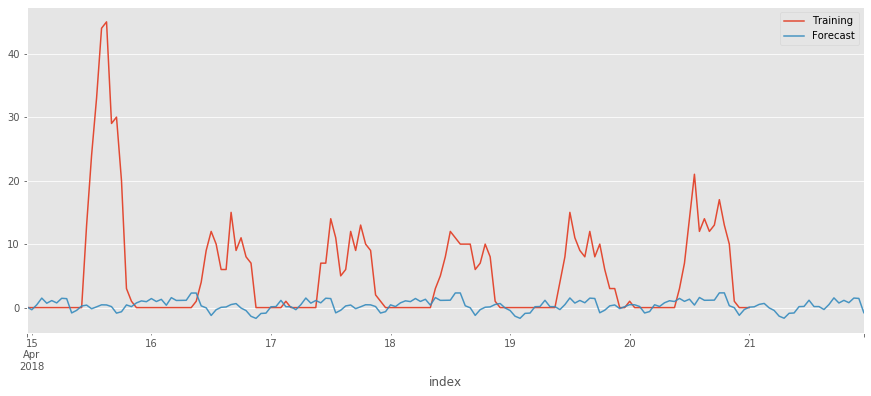

In [44]:
rcParams['figure.figsize'] = 15,6

ax = week_test_2.plot(label='Training')
pred_week_2.predicted_mean.plot(ax=ax, label = 'Forecast', alpha = 29)
plt.legend()
plt.show()

By concentrating on the weekly cycle the model has produced even worse results now that 0 values when the shop is closed are creating negative values that do not even make sense in terms of traffic. On top of that there's no clear pattern identified and our predictions are completely off the ground truths.

In [45]:
# Get the real and predicted values
traffic_forecasted = pred_week_2.predicted_mean
traffic_truth = week_test_2

# Compute the mean square error
mse = ((traffic_forecasted - traffic_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 89.93


In [46]:
traffic_forecasted.isna().sum()

0

In [47]:
traffic_truth.isna().sum()

0

In [48]:
traffic_truth

index
2018-04-14 23:00:00     0.0
2018-04-15 00:00:00     0.0
2018-04-15 01:00:00     0.0
2018-04-15 02:00:00     0.0
2018-04-15 03:00:00     0.0
                       ... 
2018-04-20 20:00:00    10.0
2018-04-20 21:00:00     1.0
2018-04-20 22:00:00     0.0
2018-04-20 23:00:00     0.0
2018-04-21 00:00:00     0.0
Name: Value, Length: 146, dtype: float64

# TBATS to deal with multiple seasonalities

It has become quite clear that one of the main challenges for this modelling is the presence of multiple seasonalities which the ARIMA family of models do not handle very well.

The pattern of missing values was somewhat picked up by the first iteration of SARIMA on daily cycles. However, performance was quite low.

I am introducing a different statistical package that it is more appropriate in handling mutiple seasonalities: TBATS.

Each seasonality is modeled by a trigonometric representation based on Fourier series.
One of the limitations of this model is that it does not take any exogenous variables like the SARIMAX counterpart would do. Having said that, the SARIMA model was already struggling quite a bit in this context and adding exogenous variables would have not helped by a lot in this case.

It is true that we could have used exogenous variables to determine opening hours for the shop. Still the multiple seasonality problem would have persisted even in that scenario, probably leading to poor performance.

The name TBATS stands for: Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components. 

##  Modelling

I am setting the model to pick daily (24) and weekly (168) cycle at the same time.
The model takes quite a while to run and I have pickled it for convenience.

In [49]:
# # # Fit the model
# estimator = TBATS(seasonal_periods= [24, 168])
# #                   use_arma_errors=False,  # shall try only models without ARMA
# #                    use_box_cox=False)
# model = estimator.fit(data_training_2)

In [50]:
# model

In [51]:
# dump(model, 'model_tbats')

In [52]:
model= load('model_tbats') 

Having a look at what this model is doing in teh backend, we can see that 6 seasonal harmonics are used to model both the daily pattern and weekly patterns. Trend is not being modeled and ARMA is used to model residuals with p 4 and q 2 parameters.

In [53]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [ 24. 168.]
Seasonal harmonics [6 6]
ARMA errors (p, q): (4, 2)
Smoothing (Alpha): 0.006080
Seasonal Parameters (Gamma): [ 1.01238838e-04 -4.86718846e-04  2.28595997e-04  3.94537645e-07]
AR coefficients [ 2.28595997e-04  3.94537645e-07  4.27195937e-01 -1.00400416e-01]
MA coefficients [0.75083642 0.62583376]
Seed vector [12.03678043 -9.17280513  0.7439294  -0.902447    1.20280116 -0.27108476
  0.37918185 -8.93766774  5.06490738 -0.49684315  0.4786667   0.0618064
 -0.35739277  2.14764919 -1.15559507 -0.88859214  0.28228658  1.35894976
  0.66901145 -3.91269603 -1.73648882  0.16043477  0.4124056  -0.39735161
 -3.29195569  0.          0.          0.          0.          0.
  0.        ]

AIC 22916.060239


Printing out below some of the initial predictions and forecasts provided by TBATS. 
I am referring to predictions as the model guesses over the training data set while forecasting are the results created by the model for unseen data. 

I can already see that there are quite a few negative values which do not make sense in this context. This time, I'll round all negative values to 0 in order to increase performance for the model.

In [54]:
    print('\n\nIN SAMPLE PREDICTIONS\n\n')
    print('Original time series (20 first values)', model.y[:20])
    print('Predictions (20 first values)', model.y_hat[:20])
    print('Residuals (20 first values)', model.resid[:20])



IN SAMPLE PREDICTIONS


Original time series (20 first values) [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  3. 12. 23. 26. 41. 43. 45. 31.
 22. 18.]
Predictions (20 first values) [ 6.43006572e+00  1.91791604e-01 -3.58433431e-01  4.32267841e-01
  3.11643464e-01 -9.67525240e-01 -2.77403995e-01 -1.85496511e-02
 -1.17245044e+00  2.12662052e-01  5.72189431e+00  1.15215934e+01
  1.91074561e+01  2.61221413e+01  2.71781561e+01  3.71198828e+01
  3.83376222e+01  3.76353133e+01  2.45685277e+01  1.69614585e+01]
Residuals (20 first values) [-6.43006572 -0.1917916   0.35843343 -0.43226784 -0.31164346  0.96752524
  0.277404    0.01854965  1.17245044  0.78733795 -2.72189431  0.47840659
  3.89254395 -0.12214128 13.82184387  5.88011725  6.6623778  -6.63531327
 -2.56852774  1.0385415 ]


Finding out how long our test_set is in terms of hours.

In [55]:
len(data_test_2) 

862

In [56]:
data_test_2.index.min()

Timestamp('2018-04-01 00:00:00')

In [57]:
data_test_2.index.max()

Timestamp('2018-05-06 21:00:00')

At this point, we'll create a forecast object for the number of hours in our test set (862)

In [58]:
model_forecasted = model.forecast(steps=862)

In [59]:
model_forecasted[:20]

array([ 1.19266105,  0.07446047,  0.3817801 ,  0.81943402, -0.0685607 ,
        0.43326041,  1.14864522,  0.74454323,  2.2263618 ,  7.96516125,
       16.69964919, 24.51001392, 28.58965994, 30.0111505 , 30.34495588,
       29.1271641 , 26.33006944, 22.89762428, 18.69399671, 13.17385261])

## Building df to plot all results

### Dataframe for model predictions on training dataset

In [60]:
print(len(model.y))
print(len(model.y_hat))

2161
2161


In [61]:
pred = pd.Series(model.y_hat)

In [62]:
new_1 = pred.reset_index()

In [63]:
new_1.drop('index', axis =1, inplace=True)

In [64]:
# generating a period range equivalent to the length of training set
dates = pd.period_range(start = '2018-01-01 00:00:00', end = '2018-04-01 00:00:00', freq='H')
dates = dates.to_series()

In [65]:
# creating temporary df to be merged
new = dates.reset_index().drop(columns=0,axis=1)

In [66]:
new

,index
0,2018-01-01 00:00
1,2018-01-01 01:00
2,2018-01-01 02:00
3,2018-01-01 03:00
4,2018-01-01 04:00
...,...
2156,2018-03-31 20:00
2157,2018-03-31 21:00
2158,2018-03-31 22:00
2159,2018-03-31 23:00


In [67]:
# saving temporary df for the final  merging
new_1.rename(columns={0:'pred'}, inplace=True)

In [68]:
new_1.head(5)

,pred
0,6.430066
1,0.191792
2,-0.358433
3,0.432268
4,0.311643


The final dataframe with TBATS predictions on the initial training dataset is below:

In [69]:
df_predictions_train = pd.concat([new, new_1], axis=1, join = 'outer')
df_predictions_train.head()

,index,pred
0,2018-01-01 00:00,6.430066
1,2018-01-01 01:00,0.191792
2,2018-01-01 02:00,-0.358433
3,2018-01-01 03:00,0.432268
4,2018-01-01 04:00,0.311643


### Dataframe for forecast predictions on test dataset

In [70]:
# generating period range equivalent to the forecast
dates_for = pd.period_range(start = '2018-04-01 00:00:00', end = '2018-05-06 21:00:00', freq='H')
# converting to series
dates_for = dates_for.to_series()


It's matching the length of our forecast.

In [71]:
len(dates_for)

862

In [72]:
# resetting the index and dropping extra column
for_new = dates_for.reset_index().drop(columns=0,axis=1)

Transforming the previously created numpy array of forecasts into a series.

In [73]:
# tranforming into series
df_for_pre_ = pd.Series(model_forecasted)


In [74]:
# resetting index
df_for_pre_ = df_for_pre_.reset_index()
df_for_pre_.rename(columns={0:'forecast'}, inplace=True)
df_for_pre_.drop(columns='index',inplace=True, axis=1)

In [75]:
df_for_pre_

,forecast
0,1.192661
1,0.074460
2,0.381780
3,0.819434
4,-0.068561
...,...
857,22.890669
858,18.689822
859,13.184763
860,7.620503


Creating final df with all the forecasts for our test.

In [76]:
df_forecast = pd.concat([for_new,df_for_pre_], axis=1)

In [77]:
df_forecast

,index,forecast
0,2018-04-01 00:00,1.192661
1,2018-04-01 01:00,0.074460
2,2018-04-01 02:00,0.381780
3,2018-04-01 03:00,0.819434
4,2018-04-01 04:00,-0.068561
...,...,...
857,2018-05-06 17:00,22.890669
858,2018-05-06 18:00,18.689822
859,2018-05-06 19:00,13.184763
860,2018-05-06 20:00,7.620503


### Rounding all data and setting to time series

I'll round to 0 all the results smaller than 1 just to make the model more accurate and remove the noise across the hours where the shop is closed.

In [78]:
# rounding all results close to 0 for the prediction on the training data set
df_predictions_train.loc[df_predictions_train['pred'] <1, 'pred'] = 0
# rounding all other numbers
df_predictions_train['pred'].round()


0        6.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
2156    21.0
2157     8.0
2158     0.0
2159     0.0
2160     0.0
Name: pred, Length: 2161, dtype: float64

In [79]:
# converting the index to string first as it was running an error before of previous index datatype
df_predictions_train['index'] = df_predictions_train['index'].astype(str)

In [80]:
# converting index to datetime
df_predictions_train['index'] = pd.to_datetime(df_predictions_train['index'])
# setting column index to index
df_predictions_train.set_index('index', inplace = True)

In [81]:
df_predictions_train.head()

,pred
index,
2018-01-01 00:00:00,6.430066
2018-01-01 01:00:00,0.000000
2018-01-01 02:00:00,0.000000
2018-01-01 03:00:00,0.000000
2018-01-01 04:00:00,0.000000


In [82]:
# rounding all results close to 0 for the forecast on test set
df_forecast.loc[(df_forecast['forecast'] <1), 'forecast'] = 0
# rounding all other numbers
df_forecast.round()

,index,forecast
0,2018-04-01 00:00,1.0
1,2018-04-01 01:00,0.0
2,2018-04-01 02:00,0.0
3,2018-04-01 03:00,0.0
4,2018-04-01 04:00,0.0
...,...,...
857,2018-05-06 17:00,23.0
858,2018-05-06 18:00,19.0
859,2018-05-06 19:00,13.0
860,2018-05-06 20:00,8.0


In [83]:
# converting the index to string first as it was running an error before of previous index datatype
df_forecast['index'] = df_forecast['index'].astype(str)

In [84]:
# converting index to datetime
df_forecast['index'] = pd.to_datetime(df_forecast['index'])
# setting column index to index
df_forecast.set_index('index', inplace = True)

In [85]:
df_forecast.head()

,forecast
index,
2018-04-01 00:00:00,1.192661
2018-04-01 01:00:00,0.000000
2018-04-01 02:00:00,0.000000
2018-04-01 03:00:00,0.000000
2018-04-01 04:00:00,0.000000


## Visualising Results

The model has finally picked up both daily and weekly trends. However, we can still see that it's still coming up with negative results for oveernight predictions even on teh training.

In [86]:
# making df into Series
df_predictions_train = df_predictions_train['pred']

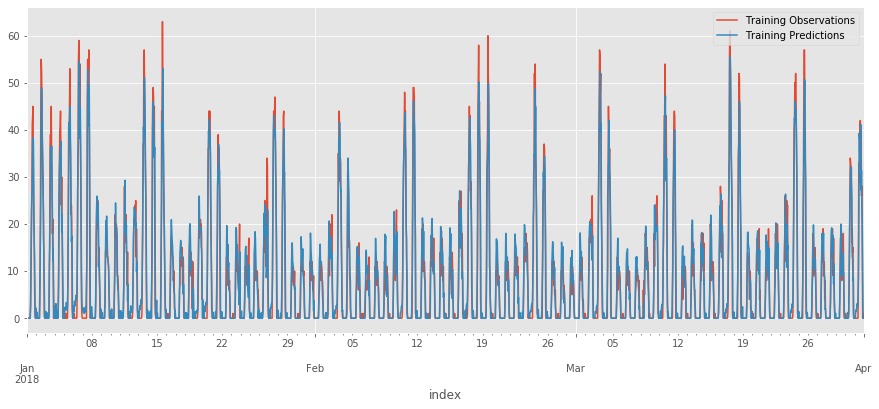

In [87]:
fig, ax1 = plt.subplots()

ax1 = data_training_2.plot(label = 'Training Observations')
ax1 = df_predictions_train.plot (label = 'Training Predictions')



plt.legend()
plt.show()


In [88]:
# Get the real and predicted values
traffic_1 = data_training_2
traffic_2 = df_predictions_train

# Compute the mean square error
mse = ((traffic_1 - traffic_2) ** 2).mean()
print('The Mean Squared Error of our training data is {}'.format(round(mse, 2)))

The Mean Squared Error of our training data is 17.49


Results are much better even for the forecasting sections on the test set which ranges from April to end of May with a final mean squared error of 17 on the training set.

In [89]:
df_forecast = df_forecast['forecast']

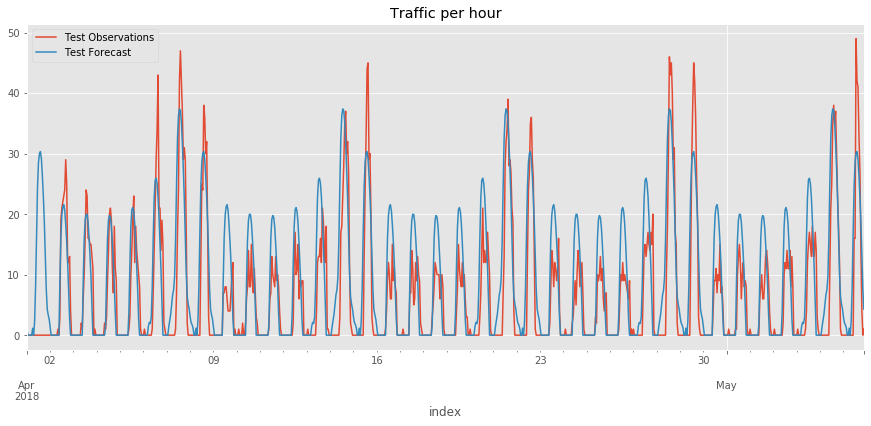

In [117]:
rcParams['figure.figsize'] = 15,6

plt.title('Traffic per hour')

ax = data_test_2.plot(label = 'Test Observations')
ax = df_forecast.plot(label = 'Test Forecast')



plt.legend()
plt.show()


In [91]:
# Get the real and predicted values
traffic_3 = data_test_2
traffic_4 = df_forecast

# Compute the mean square error
mse = ((traffic_3 - traffic_4) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 43.95


On the final forecast, we managed to halve the MSE and **drop to around 40** which is quite good given the complexity of this problem. This final model has managed to find some nuances into the intra-seasonal variations of weeks and days.

However, monthly and yearly cycles are not included in this model and, as for any other time series model, inaccuracies will be growing significantly going into the end of the year.


We are ready to make the final forecast for the extra month outside the dataset.

# Final Forecast for the extra month in terms of traffic

As we know that our dataset finishes on the 6th of May, we'll want to make forecasts until the 6th of June.

There are 745 hours in between the 5th of May and the 5th of June.

So we'll need to deploy the TBATS model to make forecasts of 862 (previous test set) + 745 (one more month) for June which amounts to 1607 hours.

In [92]:
# double checking amount of hours in between the 6th of May and the 6th of June 
pd.period_range(start = '2018-05-06 21:00', end = '2018-06-06 21:00', freq = 'H')

PeriodIndex(['2018-05-06 21:00', '2018-05-06 22:00', '2018-05-06 23:00',
             '2018-05-07 00:00', '2018-05-07 01:00', '2018-05-07 02:00',
             '2018-05-07 03:00', '2018-05-07 04:00', '2018-05-07 05:00',
             '2018-05-07 06:00',
             ...
             '2018-06-06 12:00', '2018-06-06 13:00', '2018-06-06 14:00',
             '2018-06-06 15:00', '2018-06-06 16:00', '2018-06-06 17:00',
             '2018-06-06 18:00', '2018-06-06 19:00', '2018-06-06 20:00',
             '2018-06-06 21:00'],
            dtype='period[H]', length=745, freq='H')

In [93]:
# forecast for the extra month
model_forecasted_f = model.forecast(steps=1607)

## Building the dfs for forecast and dates

Generating the dates for the relevant period of time

In [94]:
# generating period range equivalent to the forecast
dates_for_final = pd.period_range(start = '2018-04-01 00:00:00', end = '2018-06-06 22:00:00', freq='H')
# converting to series
dates_for_final = dates_for_final .to_series()


In [95]:
dates_for_final 

2018-04-01 00:00    2018-04-01 00:00
2018-04-01 01:00    2018-04-01 01:00
2018-04-01 02:00    2018-04-01 02:00
2018-04-01 03:00    2018-04-01 03:00
2018-04-01 04:00    2018-04-01 04:00
                          ...       
2018-06-06 18:00    2018-06-06 18:00
2018-06-06 19:00    2018-06-06 19:00
2018-06-06 20:00    2018-06-06 20:00
2018-06-06 21:00    2018-06-06 21:00
2018-06-06 22:00    2018-06-06 22:00
Freq: H, Length: 1607, dtype: period[H]

In [96]:
# resetting the index and dropping extra column
for_new_1 = dates_for_final .reset_index().drop(columns=0,axis=1)

In [97]:
for_new_1.head()

,index
0,2018-04-01 00:00
1,2018-04-01 01:00
2,2018-04-01 02:00
3,2018-04-01 03:00
4,2018-04-01 04:00


Transforming the forecast into a series

In [98]:
# tranforming into series
df_extra_for = pd.Series(model_forecasted_f)


In [99]:
# resetting index
df_extra_for = df_extra_for.reset_index()


In [100]:
df_extra_for.rename(columns={0:'forecast'}, inplace=True)
df_extra_for.drop(columns='index',inplace=True, axis=1)

In [101]:
df_extra_for.head()

,forecast
0,1.192661
1,0.074460
2,0.381780
3,0.819434
4,-0.068561


In [102]:
# concat the two dfs

final_df = pd.concat([for_new_1,df_extra_for], axis = 1)

In [103]:
final_df

,index,forecast
0,2018-04-01 00:00,1.192661
1,2018-04-01 01:00,0.074460
2,2018-04-01 02:00,0.381780
3,2018-04-01 03:00,0.819434
4,2018-04-01 04:00,-0.068561
...,...,...
1602,2018-06-06 18:00,8.238083
1603,2018-06-06 19:00,3.581309
1604,2018-06-06 20:00,-0.882445
1605,2018-06-06 21:00,-2.887424


## Rounding all data and setting to time series

Similarly to what has been done before on out test and training set, we'll also set to 0 all values less than 1 person. Also, this data still needs to be converted into a time series.

In [104]:
# rounding all results close to 0 for the prediction on the training data set
final_df.loc[final_df['forecast'] <1, 'forecast'] = 0
# rounding all other numbers
final_df['forecast'].round()


0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1602    8.0
1603    4.0
1604    0.0
1605    0.0
1606    0.0
Name: forecast, Length: 1607, dtype: float64

In [105]:
# converting the index to string first as it was running an error before of previous index datatype
final_df['index'] = final_df['index'].astype(str)

In [106]:
# converting index to datetime
final_df['index'] = pd.to_datetime(final_df['index'])
# setting column index to index
final_df.set_index('index', inplace = True)

In [107]:
# making df into Series
final_df = final_df['forecast']

At this point, we are selecting only the values after the 6th of May until the end of the avalable data to have our final forecast for the extra month.

In [108]:
final_df_vis = final_df['2018-05-06':]

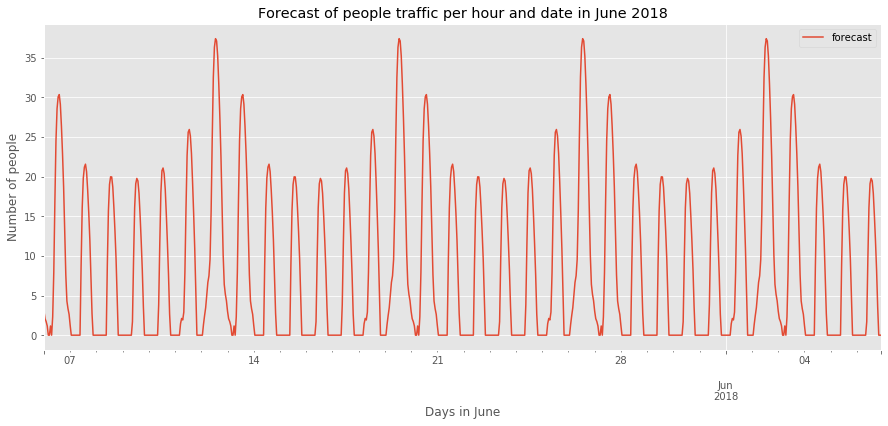

In [109]:
fig, ax = plt.subplots()
ax = final_df_vis.plot()
plt.title('Forecast of people traffic per hour and date in June 2018')

ax.set_xlabel('Days in June')
ax.set_ylabel('Number of people')
plt.legend()


# (Appendix) Facebook Prophet

In [110]:
df_pre = df[train_start:test_end]

In [111]:
df_pre.reset_index(inplace=True)
df_pre = df_pre.rename(columns={'index':'ds', 'Value':'y'})


In [112]:
df_pre.drop(['Holiday','time', 'mdate', 'day', 'week','month','year'], axis = 1, inplace=True)

In [113]:
df_prophet = fbprophet.Prophet(changepoint_prior_scale=.10)
df_prophet.fit(df_pre)


In [114]:
# make a future df for 2 months
df_pre_forecast = df_prophet.make_future_dataframe (periods = 3000, freq = 'H')
df_pre_forecast = df_prophet.predict(df_pre_forecast)

Text(0.5, 1, 'Traffic Forecast')

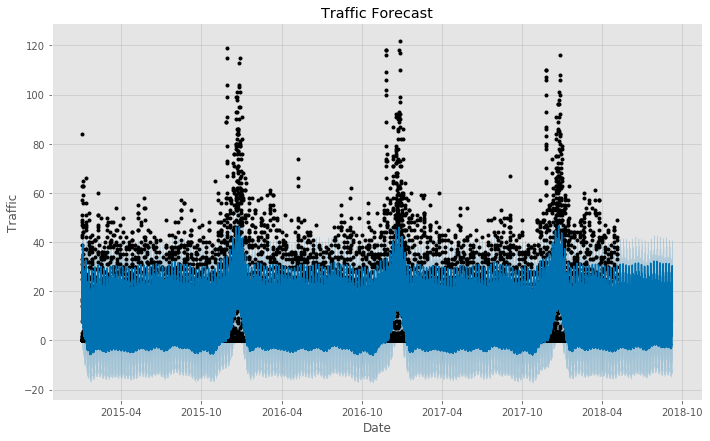

In [115]:
df_prophet.plot(df_pre_forecast, xlabel = 'Date', ylabel = 'Traffic')
plt.title('Traffic Forecast')

In [116]:
test_end_2    = pd.to_datetime('20180506 2100', format='%Y-%m-%d %H:%M')

In [ ]:

# y_arima_forecast = arima_model.predict(n_periods=100)